In [ ]:
# Imports here
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import torchvision.models as models
from PIL import Image
import json
from matplotlib.ticker import FormatStrFormatter
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data_dir = '/content/drive/My Drive/Colab Notebooks/'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [ ]:
# Training transform includes random rotation and flip to build a more robust model
train_transforms = transforms.Compose([transforms.Resize((244,244)),
                                       transforms.RandomRotation(30),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


# The validation set will use the same transform as the test set
test_transforms = transforms.Compose([transforms.Resize((244,244)),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

validation_transforms = transforms.Compose([transforms.Resize((244,244)),
                                            transforms.CenterCrop(224),
                                            transforms.ToTensor(),
                                            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


# Load the datasets with ImageFolder
train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
test_data = datasets.ImageFolder(data_dir + '/test', transform=test_transforms)
valid_data = datasets.ImageFolder(data_dir + '/valid', transform=validation_transforms)

# Using the image datasets and the trainforms, define the dataloaders
# The trainloader will have shuffle=True so that the order of the images do not affect the model
trainloader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=16, shuffle=True)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=16, shuffle=True)

In [ ]:

#model = models.densenet121(pretrained=True)
model = models.resnet34(pretrained=True)

In [ ]:
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 196)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
lrscheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, threshold = 0.9)

In [ ]:
def validation(model, validloader, criterion):
    valid_loss = 0
    accuracy = 0
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    # change model to work with cuda
    model.to('device')

    # Iterate over data from validloader
    for ii, (images, labels) in enumerate(validloader):
    
        # Change images and labels to work with cuda
        images, labels = images.to(device), labels.to(device)

        # Forward pass image though model for prediction
        output = model.forward(images)
        # Calculate loss
        valid_loss += criterion(output, labels).item()
        # Calculate probability
        ps = torch.exp(output)
        
        # Calculate accuracy
        equality = (labels.data == ps.max(dim=1)[1])
        accuracy += equality.type(torch.FloatTensor).mean()
    
    return valid_loss, accuracy

In [ ]:
epochs = 5
steps = 0
print_every = 40

# change to gpu mode
model.to(device)
model.train()
for e in range(epochs):

    running_loss = 0
    
    # Iterating over data to carry out training step
    for ii, (inputs, labels) in enumerate(trainloader):
        steps += 1
        
        inputs, labels = inputs.to(device), labels.to(device)
        
        # zeroing parameter gradients
        optimizer.zero_grad()
        
        # Forward and backward passes
        outputs = model.forward(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        # Carrying out validation step
        if steps % print_every == 0:
            # setting model to evaluation mode during validation
            model.eval()
            
            # Gradients are turned off as no longer in training
            with torch.no_grad():
                valid_loss, accuracy = validation(model, validloader, criterion)
            
            print(f"No. epochs: {e+1}, \
            Training Loss: {round(running_loss/print_every,3)} \
            Valid Loss: {round(valid_loss/len(validloader),3)} \
            Valid Accuracy: {round(float(accuracy/len(validloader)),3)}")
            
            
            # Turning training back on
            model.train()
            lrscheduler.step(accuracy * 100)

In [ ]:
correct = 0
total = 0
model.to(device)


with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        # Get probabilities
        outputs = model(images)
        # Turn probabilities into predictions
        _, predicted_outcome = torch.max(outputs.data, 1)
        # Total number of images
        total += labels.size(0)
        # Count number of cases in which predictions are correct
        correct += (predicted_outcome == labels).sum().item()

print(f"Test accuracy of model: {round(100 * correct / total,3)}%")

Test accuracy of model: 96.203%


In [ ]:
# Saving: feature weights, new model.fc, index-to-class mapping, optimiser state, and No. of epochs
checkpoint = {'state_dict': model.state_dict(),
              'model': model.fc,
              'class_to_idx': train_data.class_to_idx,
              'opt_state': optimizer.state_dict,
              'num_epochs': epochs}

torch.save(checkpoint, '/content/drive/My Drive/Colab Notebooks/test/my_checkpoint1.pth')

In [ ]:
# Write a function that loads a checkpoint and rebuilds the model

def load_checkpoint(filepath):

    checkpoint = torch.load(filepath)
    
    #model.load_state_dict(checkpoint['state_dict'])
    model.load_state_dict(checkpoint['state_dict'], strict=False)
    model.class_to_idx = checkpoint['class_to_idx']
    
    return model

In [ ]:
# Loading model
model = load_checkpoint('/content/drive/My Drive/Colab Notebooks/test/my_checkpoint1.pth')
# Checking model i.e. should have 196 output units in the classifier
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
model = torch.nn.DataParallel(model).cuda()


In [ ]:
def process_image(image):
    
    # Process a PIL image for use in a PyTorch model

    # Converting image to PIL image using image file path
    pil_im = Image.open(f'{image}' + '.jpg')

    # Building image transform
    transform = transforms.Compose([transforms.Resize((244,244)),
                                    #transforms.CenterCrop(224),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406], 
                                                         [0.229, 0.224, 0.225])]) 
    
    # Transforming image for use with network
    pil_tfd = transform(pil_im)
    
    # Converting to Numpy array 
    array_im_tfd = np.array(pil_tfd)
    
    return array_im_tfd

In [ ]:
def imshow(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

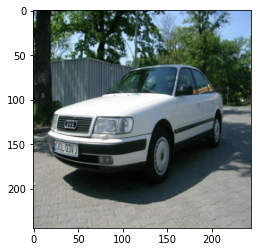

In [ ]:
imshow(process_image(data_dir + 'audi100'))

In [ ]:
def predict(image_path, model, topk=5):
    # Implement the code to predict the class from an image file   
    
    # Loading model - using .cpu() for working with CPUs
    loaded_model = load_checkpoint(model).cpu()
    # Pre-processing image
    img = process_image(image_path)
    # Converting to torch tensor from Numpy array
    img_tensor = torch.from_numpy(img).type(torch.FloatTensor)
    # Adding dimension to image to comply with (B x C x W x H) input of model
    img_add_dim = img_tensor.unsqueeze_(0)

    # Setting model to evaluation mode and turning off gradients
    loaded_model.eval()
    with torch.no_grad():
        # Running image through network
        output = loaded_model.forward(img_add_dim)
        
    #conf, predicted = torch.max(output.data, 1)   
    probs_top = output.topk(topk)[0]
    predicted_top = output.topk(topk)[1]
    
    # Converting probabilities and outputs to lists
    conf = np.array(probs_top)[0]
    predicted = np.array(predicted_top)[0]
        
    #return probs_top_list, index_top_list
    return conf, predicted

In [ ]:
# tie the class indices to their names

def find_classes(dir):
    classes = os.listdir(dir)
    classes.sort()
    class_to_idx = {classes[i]: i for i in range(len(classes))}
    return classes, class_to_idx
classes, c_to_idx = find_classes(data_dir+"train")

print(classes, c_to_idx)

['Audi 100 Sedan', 'Bentley Arnage Sedan'] {'Audi 100 Sedan': 0, 'Bentley Arnage Sedan': 1}


In [ ]:
model_path = '/content/drive/My Drive/Colab Notebooks/test/my_checkpoint1.pth'
image_path = data_dir + 'audi100'

conf1, predicted1 = predict(image_path, model_path, topk=5)

print(conf1)
print(classes[predicted1[0]])

[43.675224  36.147556   1.4972929  1.426249   1.1667225]
Audi 100 Sedan


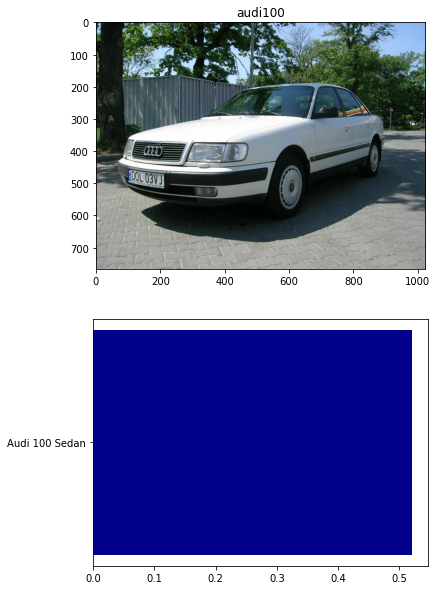

In [ ]:
# Testing predict function

# Inputs are paths to saved model and test image
model_path = '/content/drive/My Drive/Colab Notebooks/test/my_checkpoint1.pth'
carname = 'audi100'
image_path = data_dir + carname


conf2, predicted1 = predict(image_path, model_path, topk=5)
# Converting classes to names
names = []
for i in range(1):
  
    names += [classes[predicted1[i]]]

# Creating PIL image
image = Image.open(image_path+'.jpg')

# Plotting test image and predicted probabilites
f, ax = plt.subplots(2,figsize = (6,10))

ax[0].imshow(image)
ax[0].set_title(carname)

y_names = np.arange(len(names))
ax[1].barh(y_names, conf2/conf2.sum(), color='darkblue')
ax[1].set_yticks(y_names)
ax[1].set_yticklabels(names)
ax[1].invert_yaxis() 

plt.show()

In [ ]:
def plot_solution(cardir, model):
  # Testing predict function

  # Inputs are paths to saved model and test image
  model_path = '/content/drive/My Drive/Colab Notebooks/test/my_checkpoint1.pth'
  image_path = test_dir + cardir
  carname = cardir.split('/')[1]

  conf2, predicted1 = predict(image_path, model_path, topk=5)
  # Converting classes to names
  names = []
  for i in range(1):
  
      names += [classes[predicted1[i]]]


  # Creating PIL image
  image = Image.open(image_path+'.jpg')

  # Plotting test image and predicted probabilites
  f, ax = plt.subplots(2,figsize = (6,10))

  ax[0].imshow(image)
  ax[0].set_title(carname)

  y_names = np.arange(len(names))
  ax[1].barh(y_names, conf2/conf2.sum(), color='darkblue')
  ax[1].set_yticks(y_names)
  ax[1].set_yticklabels(names)
  ax[1].invert_yaxis() 

  plt.show()

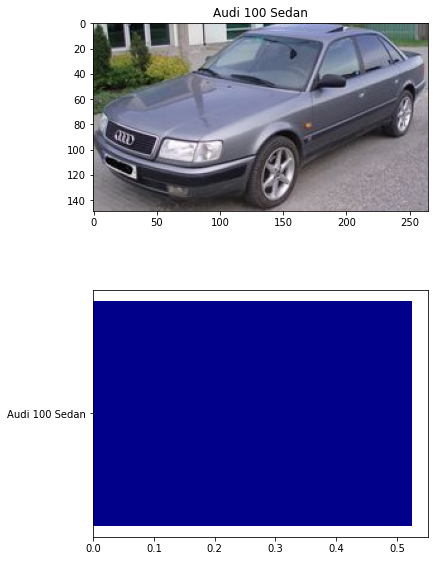

In [ ]:
cardir='/Audi 100 Sedan/01335'
plot_solution(cardir, model)

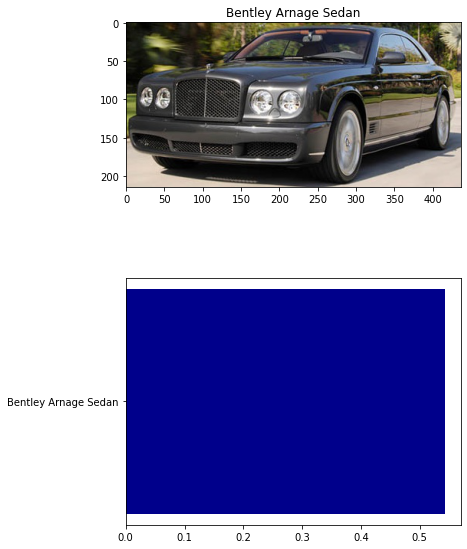

In [ ]:
cardir='/Bentley Arnage Sedan/00277'
plot_solution(cardir, model)

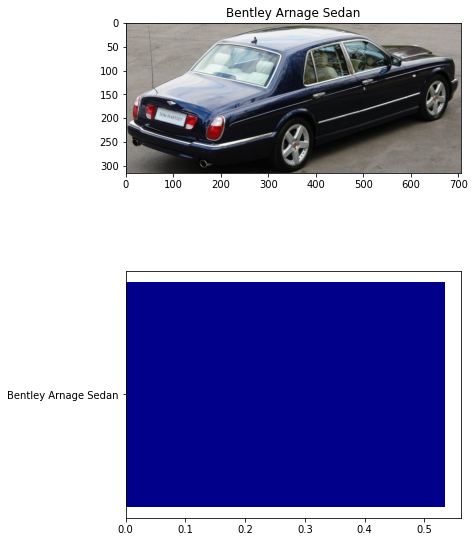

In [ ]:
cardir='/Bentley Arnage Sedan/03161'
plot_solution(cardir, model)